In [1]:
from dotenv import load_dotenv
import os
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

load_dotenv()

csv_path = os.getenv("DATA_CSV")
parquet_path = os.getenv("DATA_PARQUET")
sample_path = os.getenv("DATA_SAMPLE")
unlabeled_path = os.getenv("DATA_UNLABELED")
coretopics_path = os.getenv("DATA_CORETOPICS")

Converts large .csv file to .parquet and checks conversion. Outputs basic info on dataset.

In [6]:
if not os.path.exists(parquet_path):
    duckdb.query(f"""
    COPY (
        SELECT *
        FROM read_csv_auto(
            '{csv_path}',
            ignore_errors = true,
            sample_size = -1,
            all_varchar = true
        )
    ) TO '{parquet_path}' 
    (FORMAT PARQUET, OVERWRITE TRUE);
    """)
else:
    print(f"Parquet file already exists at {parquet_path}, skipping conversion.")

Parquet file already exists at D:\ruggbk\datasets\farmersdirect\b0cd514b-b9cc-4972-a0c2-c91726e6d825.parquet, skipping conversion.


In [7]:
# Count rows in original CSV
original_rows = duckdb.query(f"""
    SELECT COUNT(*) FROM read_csv_auto(
        '{csv_path}',
        ignore_errors = true,
        sample_size = -1
    )
""").fetchall()[0][0]


In [8]:
# Count rows in Parquet
parquet_rows = duckdb.query(f"""
    SELECT COUNT(*) FROM '{parquet_path}'
""").fetchall()[0][0]

print(f"Original rows (with ignored errors): {original_rows}")
print(f"Parquet rows: {parquet_rows}")

Original rows (with ignored errors): 20304843
Parquet rows: 20304843


In [9]:
unique_question_count = duckdb.query(f"""
    SELECT COUNT(DISTINCT question_content)
    FROM '{parquet_path}'
""").fetchall()[0][0]
print(f"# of Unique Questions: {unique_question_count}")

# of Unique Questions: 5452290


In [10]:
unique_rows_maincolumns = duckdb.query(f"""
    SELECT COUNT(DISTINCT ROW(question_id, question_content, question_topic,response_id, response_content))
    FROM '{parquet_path}'
""").fetchall()[0][0]
print(f"# of Unique Rows: {unique_rows_maincolumns}")

# of Unique Rows: 18854432


In [11]:
unique_response_count = duckdb.query(f"""
    SELECT COUNT(DISTINCT response_id)
    FROM '{parquet_path}'
""").fetchall()[0][0]
print('# of Unique Responses: ' + str(unique_response_count))

# of Unique Responses: 16283143


In [3]:
df = pd.read_parquet(parquet_path)
df.shape  # (rows, columns)
df.info()  # column types and non-null counts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20304843 entries, 0 to 20304842
Data columns (total 24 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   question_id                 object
 1   question_user_id            object
 2   question_language           object
 3   question_content            object
 4   question_topic              object
 5   question_sent               object
 6   response_id                 object
 7   response_user_id            object
 8   response_language           object
 9   response_content            object
 10  response_topic              object
 11  response_sent               object
 12  question_user_type          object
 13  question_user_status        object
 14  question_user_country_code  object
 15  question_user_gender        object
 16  question_user_dob           object
 17  question_user_created_at    object
 18  response_user_type          object
 19  response_user_status        object
 20  

In [ ]:
# unlabeled_df.to_parquet(
#     unlabeled_path,
#     engine='pyarrow',
#     index=False,
# )

In [10]:
row_language_counts = duckdb.query(f"""
    SELECT question_language, COUNT(*) AS num_questions
    FROM '{parquet_path}'
    GROUP BY question_language
    ORDER BY num_questions DESC
""").fetchall()

print("Row Language Breakdown:")
for lang, count in row_language_counts:
    print(f"{lang}: {count}")


Row Language Breakdown:
eng: 11976781
swa: 6480848
nyn: 1157228
lug: 689986


In [11]:
question_language_counts = duckdb.query(f"""
    SELECT question_language, COUNT(DISTINCT question_id) AS num_questions
    FROM '{parquet_path}'
    GROUP BY question_language
    ORDER BY num_questions DESC
""").fetchall()

print("Unique Question Language Breakdown:")
for lang, count in question_language_counts:
    print(f"{lang}: {count}")

Unique Question Language Breakdown:
eng: 2940542
swa: 2225974
nyn: 433345
lug: 265958


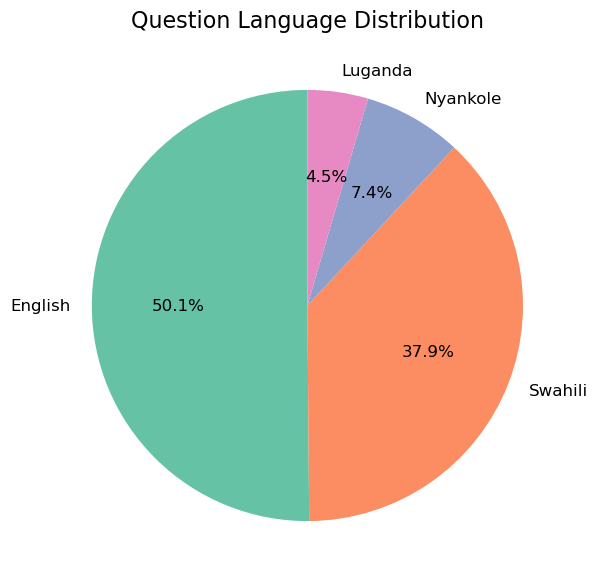

In [13]:
# Map language codes to full names
lang_names = {
    'eng': 'English',
    'swa': 'Swahili',
    'nyn': 'Nyankole',
    'lug': 'Luganda'
}

# Query the dataset into a pandas DataFrame
language_df = duckdb.query(f"""
    SELECT question_language, COUNT(DISTINCT question_id) AS num_questions
    FROM '{parquet_path}'
    GROUP BY question_language
    ORDER BY num_questions DESC
""").df()

# Replace codes with full names
language_df['language'] = language_df['question_language'].map(lang_names)
language_df['percent'] = language_df['num_questions'] / language_df['num_questions'].sum() * 100

# Pie chart
plt.figure(figsize=(7,7))
plt.pie(language_df['num_questions'], 
        labels=language_df['language'], 
        autopct='%1.1f%%', 
        startangle=90,
        textprops={'fontsize': 12},
        colors=['#66c2a5','#fc8d62','#8da0cb','#e78ac3'])
plt.title("Question Language Distribution", fontsize=16)
plt.show()



In [23]:
# Saves random sample of 1 million English questions / responses in DuckDB
if not os.path.exists(sample_path):
    duckdb.query(f"""
        COPY (
            SELECT *
            FROM read_parquet('{parquet_path}')
            WHERE question_language = 'eng'
              AND response_language = 'eng'
              AND response_content IS NOT NULL
            ORDER BY RANDOM()
            LIMIT 1000000
        ) TO '{sample_path}' (FORMAT PARQUET, OVERWRITE TRUE);
    """)
    print(f"Sample saved to {sample_path}")
else:
    print(f"Sample file already exists at {sample_path}, skipping sampling.")


Sample file already exists at D:\ruggbk\datasets\farmersdirect\farmers_1mil_eng_sample.parquet, skipping sampling.


In [ ]:
# check sampling
pd.read_parquet(sample_path)

,question_id,question_user_id,question_language,question_content,question_topic,question_sent,response_id,response_user_id,response_language,response_content,...,question_user_country_code,question_user_gender,question_user_dob,question_user_created_at,response_user_type,response_user_status,response_user_country_code,response_user_gender,response_user_dob,response_user_created_at
0,50871840,2942156,eng,Q Why Wefarm Doesn't Prepare Our Promotion?,None,2020-12-02 17:00:20.667286+00,50872828,269315,eng,Q451 it is the work of the org committee,...,ug,None,None,2020-03-06 13:36:15.449684+00,farmer,live,ug,None,None,2017-07-20 11:24:28+00
1,24215668,1004601,eng,what is mixed farming,None,2019-04-25 15:07:44.78925+00,24222344,225067,eng,Q 418 Refers to growing of various crops on sa...,...,ug,None,None,2018-07-20 14:24:34.186844+00,farmer,live,ug,male,1984-10-28,2017-06-12 17:02:07+00
2,34970005,2697773,eng,Q to 6333 wc diseases that attack maize plant?,plant,2019-12-03 07:19:06.001165+00,34970061,1844517,eng,I don't no,...,ug,None,None,2019-11-25 15:12:45.486055+00,farmer,live,ug,None,None,2019-01-23 12:54:10.444483+00
3,47631987,963431,eng,What type of maize is good plant,maize,2020-09-30 12:14:43.623567+00,47632870,3249306,eng,"if for selling,popckons but if for food consu...",...,ug,None,None,2018-07-04 06:58:43.074057+00,farmer,live,ug,None,None,2020-07-26 16:23:11.415517+00
4,56862473,3474362,eng,Q what are the seedling,None,2021-05-26 19:02:20.503138+00,56888364,3327551,eng,Q22 seedling are grown plants in seedbed for t...,...,ke,None,None,2020-11-27 08:44:57.419151+00,farmer,live,ke,None,None,2020-09-17 17:53:24.140724+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,5338768,359662,eng,How will you know that your cow is on heat,cattle,2018-03-24 16:00:30.163638+00,5345552,389259,eng,Q16 the cow mounts other cows,...,ke,None,None,2017-09-14 17:17:13+00,farmer,zombie,ke,None,None,2017-09-26 04:29:58+00
999996,29654231,2361244,eng,Which pest that attack the root of tea and how...,tea,2019-08-08 18:18:55.308216+00,29671088,1359668,eng,"Q99;Red ants, control used THUNDER chemical.",...,ke,None,None,2019-08-08 17:30:38.90231+00,farmer,live,ke,None,None,2018-10-18 17:42:49.166605+00
999997,7105245,938846,eng,Which Chemical Is Best In Weeding Maize?,maize,2018-06-26 15:38:23.882541+00,7109077,539166,eng,Q 105 dual gold,...,ke,None,None,2018-06-26 04:23:44.463892+00,farmer,live,ke,None,None,2017-11-27 06:38:06+00
999998,22633493,1968918,eng,Q HOW DO YOU DO AWAY WITH ACCUMULATED WASTES L...,cattle,2019-03-19 16:13:04.663386+00,22633848,1846683,eng,q11 deworm,...,ke,None,None,2019-03-19 15:58:37.464951+00,farmer,zombie,ke,None,None,2019-01-23 17:55:02.988204+00


### Brief analysis of question topics and creation of data files with:
* Unlabeled questions
* "Core topic" questions (maize, chicken, cattle, and tomato)

In [2]:
empty_topic_count = duckdb.query(f"""
    SELECT COUNT(DISTINCT question_content)
    FROM '{parquet_path}'
    WHERE question_topic IS NULL OR question_topic = ''
""").fetchall()[0][0]

print(f"# of Unique Questions with no topic: {empty_topic_count}")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# of Unique Questions with no topic: 1537291


In [41]:
# Count of unique questions by topic (all languages)
questions_df = df.drop_duplicates(subset=['question_content'])

for topic, count in questions_df['question_topic'].value_counts().items():
    print(topic, count)


maize 496821
chicken 407660
cattle 402574
tomato 306108
poultry 255640
bean 172527
plant 129319
pig 115571
goat 111991
potato 96967
coffee 82021
crop 80967
rabbit 78112
onion 76812
rice 70970
banana 68050
cabbage 58475
animal 51415
cotton 43066
sheep 37832
watermelon 36945
peanut 34891
passion-fruit 34404
livestock 32775
tree 29146
vegetable 28647
bee 26751
kale 26675
cassava 25186
wheat 23577
sugar-cane 23454
fish 23080
millet 22207
tea 21544
duck 20051
carrot 17362
grass 16521
plantain 16196
sunflower 15377
dog 14537
bird 14459
cereal 14194
avocado 13415
capsicum 12733
sweet-potato 12467
mango 11188
melon 10555
spinach 8653
napier-grass 7977
pea 7630
orange 7410
chilli 7074
pigeon 7003
ginger 6797
pineapple 6719
soya 6672
mushroom 6481
aubergine 6368
guinea-fowl 5994
cowpea 5717
pumpkin 5711
cashew-nut 5630
paw-paw 5578
cat 5534
turkey 5158
tobacco 4822
apple 4461
olive 3824
garlic 3224
yam 3097
camel 2960
butternut-squash 2862
cocoa 2798
taro 2723
mung-bean 2341
african-nightshade 2

In [42]:
# Count of unique questions by topic (English only)

for topic, count in questions_df.loc[questions_df['question_language'] == 'eng', 'question_topic'].value_counts().items():
    print(topic, count)

chicken 251160
cattle 238816
maize 184029
tomato 126708
plant 114121
pig 82136
bean 75875
crop 68246
banana 65245
poultry 59679
potato 53205
rabbit 50048
cabbage 49924
goat 45777
animal 45590
coffee 42764
onion 31174
watermelon 24696
sheep 22363
kale 22011
wheat 20322
livestock 19499
bee 19331
passion-fruit 18078
cassava 16962
peanut 16713
tree 16624
tea 16372
rice 15813
fish 14248
sugar-cane 13657
carrot 12693
bird 11539
grass 11373
millet 11064
vegetable 9225
dog 8843
duck 7640
mango 6971
melon 6387
orange 6317
plantain 6142
sweet-potato 6026
avocado 5950
aubergine 5935
pumpkin 5637
capsicum 5334
pea 5000
pineapple 4196
mushroom 4122
paw-paw 4084
apple 4007
pigeon 3996
turkey 3992
cotton 3814
olive 3759
spinach 3704
soya 2913
yam 2882
sunflower 2749
napier-grass 2181
ginger 2144
cat 2094
cocoa 2093
camel 2026
garlic 1919
eucalyptus 1810
tobacco 1690
beetroot 1647
cowpea 1559
french-bean 1474
taro 1275
greens 1241
macademia 1179
mung-bean 1115
butternut-squash 1032
cereal 1018
pear 97

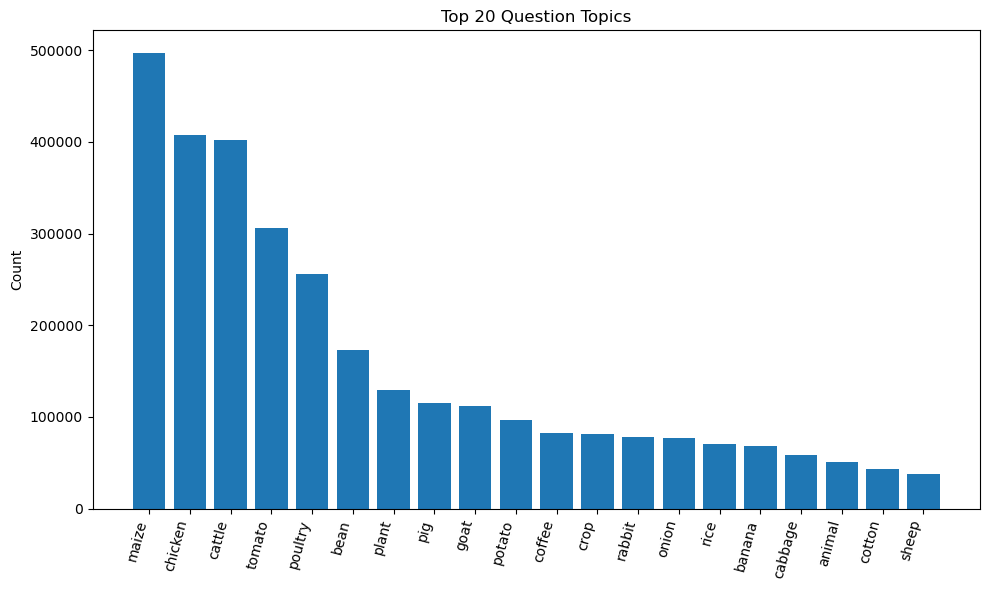

In [ ]:
# Plot the # of questions for the top 20 topics (all languages)
vc = questions_df['question_topic'].value_counts().head(20)

plt.figure(figsize=(10, 6))
plt.bar(vc.index, vc.values)
plt.xticks(rotation=75, ha='right')
plt.ylabel("Count")
plt.title("Top 20 Question Topics")
plt.tight_layout()
plt.show()


#### Save file for unlabeled questions

In [ ]:
unlabeled_df = df.loc[(df['question_topic'].isna()) & (df['question_language'] == 'eng')]
unlabeled_df.shape


In [ ]:
len(pd.unique(unlabeled_df['question_content']))

643148

In [ ]:
unlabeled_df = unlabeled_df.drop_duplicates(subset='question_content')


In [40]:
if not os.path.exists(unlabeled_path):
    unlabeled_df.to_parquet(
        unlabeled_path,
        engine='pyarrow',
        index=False,
    )

else:
    print(f"Parquet file already exists at {unlabeled_path}, skipping conversion.")

Parquet file already exists at D:\ruggbk\datasets\farmersdirect\farmers_eng_unlabeled.parquet, skipping conversion.


#### Save file for core topics questions

In [46]:
coretopics = ['chicken', 'cattle', 'maize', 'tomato']
coretopic_df = questions_df[(questions_df['question_topic'].isin(coretopics)) & (questions_df['question_language'] == 'eng')]
coretopic_df.shape

(800713, 24)

In [49]:
if not os.path.exists(coretopics_path):
    coretopic_df.to_parquet(
        coretopics_path,
        engine='pyarrow',
        index=False,
    )

else:
    print(f"Parquet file already exists at {coretopics_path}, skipping conversion.")